In [1]:
#!rm -r build
!python3 setup.py build_ext --inplace

running build_ext
copying build/lib.linux-x86_64-3.6/nice/naive.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/nice_utilities.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/packing.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/radial_basis.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/rascal_coefficients.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/spherical_coefficients.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/spherical_harmonics.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/test_parallel.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/thresholding.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/unrolling_individual_pca.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x

In [2]:
'''import sys
sys.path.insert(0, 'nice')
'''
#os.environ['OMP_NUM_THREADS'] = '24'

import numpy as np
import ase.io as ase_io
from ase import Atoms
import tqdm
import time
import copy
from sklearn.linear_model import BayesianRidge
from pathos.multiprocessing import ProcessingPool as Pool
import nice
from nice.transformers import *
from nice.parallelized import *

from matplotlib import pyplot as plt


In [3]:
def process_structures(structures):
    for structure in structures: 
        structure.cell =[120, 120, 120]
        structure.positions += np.asarray((60,60,60))
        structure.pbc=True
        structure.wrap()

In [4]:
structures_train = ase_io.read('structures.xyz', 
                         index = '0:5000')

process_structures(structures_train)

'''structures_val = ase_io.read('structures.xyz', 
                         index = '100:200')'''

#process_structures(structures_val)


"structures_val = ase_io.read('structures.xyz', \n                         index = '100:200')"

In [5]:
energies = np.load('energies.npy')
energies = energies - np.mean(energies)
energies = energies / np.sqrt(np.mean(energies * energies))
energies_train = energies[0:1000]
energies_val = energies[1000:2000]
print(energies_train.shape)
print(energies_val.shape)

(1000,)
(1000,)


In [6]:
HYPERS = {
'interaction_cutoff': 6.3,
'max_radial': 5,
'max_angular': 5,
'gaussian_sigma_type': 'Constant',
'gaussian_sigma_constant': 0.05,
'cutoff_smooth_width': 0.3,
'radial_basis': 'GTO',
}
    

In [7]:
p = Pool(40)

In [8]:
print(len(structures_train))

5000


In [9]:
coefficients = get_rascal_coefficients_parallelized(p, structures_train, HYPERS, 2)
print(coefficients.shape)
coefficients = coefficients.reshape([len(structures_train), 5, coefficients.shape[1], 
                                     coefficients.shape[2], coefficients.shape[3]])

print(coefficients.shape)

100%|██████████| 50/50 [00:03<00:00, 14.00it/s]


(25000, 10, 6, 11)
(5000, 5, 10, 6, 11)


In [10]:
'''def concatenate_data(datas):
    covariants = [datas[i].covariants_ for i in range(len(datas))]
    covariants = np.concatenate(covariants, axis = 0)
    return Data(covariants, datas[0].actual_sizes_, datas[0].importances_, datas[0].raw_importances_)

def transform_parallelized(transformer, *args, task_size = 100):
    print(len(args))
    tasks = []
    for i in range(0, args[0].shape[0], task_size):
        now = []
        for j in range(len(args)):
            now.append(args[j][i : i + task_size])
        tasks.append(now)
    
    def func(task):
        return transformer.transform(*task)
    
    result = [res for res in tqdm.tqdm(p.imap(func, tasks), total = len(tasks))]
    ans = []
    for i in range(len(result[0])):
        now = [result[j][i] for j in range(len(result))]
        ans.append(concatenate_data(now))
        
     print(len(ans))
    print(ans[0].shape)
    return ans'''

'def concatenate_data(datas):\n    covariants = [datas[i].covariants_ for i in range(len(datas))]\n    covariants = np.concatenate(covariants, axis = 0)\n    return Data(covariants, datas[0].actual_sizes_, datas[0].importances_, datas[0].raw_importances_)\n\ndef transform_parallelized(transformer, *args, task_size = 100):\n    print(len(args))\n    tasks = []\n    for i in range(0, args[0].shape[0], task_size):\n        now = []\n        for j in range(len(args)):\n            now.append(args[j][i : i + task_size])\n        tasks.append(now)\n    \n    def func(task):\n        return transformer.transform(*task)\n    \n    result = [res for res in tqdm.tqdm(p.imap(func, tasks), total = len(tasks))]\n    ans = []\n    for i in range(len(result[0])):\n        now = [result[j][i] for j in range(len(result))]\n        ans.append(concatenate_data(now))\n        \n     print(len(ans))\n    print(ans[0].shape)\n    return ans'

In [11]:
def split_coefficients(coefficients):
    c_coefficients = coefficients[:, 0]
    h_coefficients = coefficients[:, 1:]
   
    h_coefficients = np.reshape(h_coefficients, [coefficients.shape[0] * 4, 
                                              coefficients.shape[2], coefficients.shape[3],
                                              coefficients.shape[4]])
    return c_coefficients, h_coefficients

In [12]:
c_coefficients, h_coefficients = split_coefficients(coefficients)
print(c_coefficients.shape)

(5000, 10, 6, 11)


In [13]:
'''begin = time.time()
pst = BSTransformer()
pst.fit(c_coefficients)
print(time.time() - begin)'''

'begin = time.time()\npst = BSTransformer()\npst.fit(c_coefficients)\nprint(time.time() - begin)'

In [14]:
'''begin = time.time()
res = pst.transform(c_coefficients)
print(res[2].shape)
print(time.time() - begin)'''

'begin = time.time()\nres = pst.transform(c_coefficients)\nprint(res[2].shape)\nprint(time.time() - begin)'

In [15]:
def fit(coefficients, num_to_fit):
    c_coefficients, h_coefficients = split_coefficients(coefficients)
    print(c_coefficients.shape)
    begin = time.time()
    c_trans = StandardSequence([StandardBlock(ThresholdExpansioner(),
                                              None,
                                                  IndividualLambdaPCAsBoth(),
                                                  None,
                                              None,
                                                  None),
                                StandardBlock(ThresholdExpansioner(num_expand = 500),
                                              None,
                                                  IndividualLambdaPCAsBoth(100),
                                                  ThresholdExpansioner(num_expand = 1000, mode = 'invariants'),
                                              None,
                                                  None),
                                StandardBlock(ThresholdExpansioner(num_expand = 500),
                                              None,
                                                  IndividualLambdaPCAsBoth(100),
                                                  ThresholdExpansioner(num_expand = 1000, mode = 'invariants'),
                                              None,
                                                  None),
                                StandardBlock(ThresholdExpansioner(num_expand = 500),
                                              None,
                                                  IndividualLambdaPCAsBoth(100),
                                                  ThresholdExpansioner(num_expand = 1000, mode = 'invariants'),
                                              None,
                                                  None)
                                   ])
                                  

    c_trans.fit(c_coefficients[:num_to_fit])
    print(time.time() - begin)
    
    begin = time.time()
    print(h_coefficients[:num_to_fit].shape)
    h_trans = StandardSequence([StandardBlock(ThresholdExpansioner(),
                                              None,
                                                  IndividualLambdaPCAsBoth(),
                                                  None,
                                              None,
                                                  None),
                                StandardBlock(ThresholdExpansioner(num_expand = 500),
                                              None,
                                                  IndividualLambdaPCAsBoth(100),
                                                  ThresholdExpansioner(num_expand = 1000, mode = 'invariants'),
                                              None,
                                                  None),
                                StandardBlock(ThresholdExpansioner(num_expand = 500),
                                              None,
                                                  IndividualLambdaPCAsBoth(100),
                                                  ThresholdExpansioner(num_expand = 1000, mode = 'invariants'),
                                              None,
                                                  None),
                                StandardBlock(ThresholdExpansioner(num_expand = 500),
                                              None,
                                                  IndividualLambdaPCAsBoth(100),
                                                  ThresholdExpansioner(num_expand = 1000, mode = 'invariants'),
                                              None,
                                                  None)
                                   ])
    h_trans.fit(h_coefficients[:num_to_fit])
    print(time.time() - begin)
    
    return c_trans, h_trans



In [16]:
c_trans, h_trans = fit(coefficients, 5000)

(5000, 10, 6, 11)


/home/pozdn/nice/nice/transformers.py:132: RuntimeWarning: given data is less than desired number of points to fit pca. Desired number of points to fit pca is 6000, while number of vectors is 5000, dimensionality of single vector (lambd + 1) is 1, i. e. total number of points is 5000. Number of pca components is 600
  warnings.warn("given data is less than desired number of points to fit pca. Desired number of points to fit pca is {}, while number of vectors is {}, dimensionality of single vector (lambd + 1) is {}, i. e. total number of points is {}. Number of pca components is {}".format(num_fit_now, data.covariants_.shape[0], (lambd + 1), data.covariants_.shape[0] * (lambd + 1), n_components_now), RuntimeWarning)


548.7505779266357
(5000, 10, 6, 11)


/home/pozdn/nice/nice/transformers.py:132: RuntimeWarning: given data is less than desired number of points to fit pca. Desired number of points to fit pca is 6000, while number of vectors is 5000, dimensionality of single vector (lambd + 1) is 1, i. e. total number of points is 5000. Number of pca components is 600
  warnings.warn("given data is less than desired number of points to fit pca. Desired number of points to fit pca is {}, while number of vectors is {}, dimensionality of single vector (lambd + 1) is {}, i. e. total number of points is {}. Number of pca components is {}".format(num_fit_now, data.covariants_.shape[0], (lambd + 1), data.covariants_.shape[0] * (lambd + 1), n_components_now), RuntimeWarning)


437.5129005908966


In [17]:
c_coefficients, h_coefficients = split_coefficients(coefficients)


In [18]:

data_even, data_odd, invariants_even = c_trans.transform(c_coefficients[0:10])

In [19]:
print(data_even.covariants_.shape)
print(data_even.actual_sizes_)
print(data_even.importances_.shape)
print(data_even.raw_importances_)

(10, 100, 6, 11)
[ 57 100 100 100 100 100]
(100, 6)
None


In [20]:
print(len(invariants_even))
for el in invariants_even:
    print(el.shape)

5
(10, 10)
(10, 600)
(10, 1005)
(10, 1003)
(10, 1022)


In [21]:
from matplotlib import pyplot as plt

body order:  1


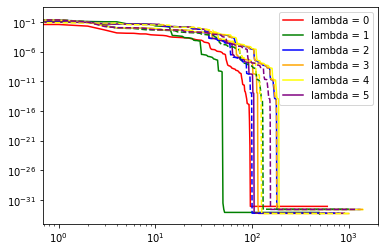

body order:  2


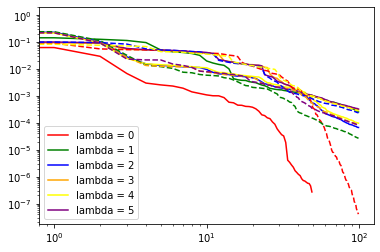

body order:  3


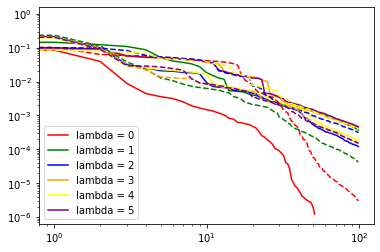

body order:  4


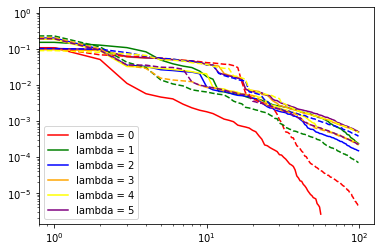

In [22]:
colors = ['r', 'g', 'b', 'orange', 'yellow', 'purple']
for nu in range(len(c_trans.blocks_)):
    print("body order: ", nu + 1)
    for i in range(6):
        if (c_trans.blocks_[nu].covariants_pca_ is not None):
            if (c_trans.blocks_[nu].covariants_pca_.even_pca_.pcas_[i] is not None):
                plt.plot(c_trans.blocks_[nu].covariants_pca_.even_pca_.pcas_[i].importances_, color = colors[i], label = "lambda = {}".format(i))
        
    
    for i in range(6):
        if (c_trans.blocks_[nu].covariants_pca_ is not None):
            if (c_trans.blocks_[nu].covariants_pca_.odd_pca_.pcas_[i] is not None):
                plt.plot(c_trans.blocks_[nu].covariants_pca_.odd_pca_.pcas_[i].importances_, '--', color = colors[i])
    
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    plt.show()